# **Experiment 6**

# **AIM : Implementation of MDP for a specific application**


# **Theory:**
## **Theory: Implementation of Markov Decision Process (MDP) for a Specific Application**

A **Markov Decision Process (MDP)** is a mathematical framework used for modeling decision-making problems in situations where outcomes are partly random and partly under the control of a decision-maker. It is widely applied in areas such as robotics, automated control, economics, and artificial intelligence for sequential decision-making problems.

An MDP is formally defined by a 4-tuple:

- **S**: A finite set of states  
- **A**: A finite set of actions  
- **P**: Transition probability matrix, where P(s′|s, a) defines the probability of moving to state *s′* from state *s* after taking action *a*  
- **R**: Reward function, which gives the immediate reward received after transitioning from state *s* to state *s′* via action *a*  

The objective in MDP is to find a **policy (π)** – a mapping from states to actions – that maximizes the expected sum of rewards over time, often referred to as the **cumulative return**. A commonly used method for solving MDPs is **dynamic programming**, particularly **Value Iteration** and **Policy Iteration** algorithms.

### **Key Properties of MDPs**

- **Markov Property**: The future state depends only on the current state and action, not on the sequence of events that preceded it.  
- **Stochastic Transitions**: The next state is determined probabilistically, reflecting uncertainty in the environment.

---

### **Applications of MDP**

MDPs are used in various domains, such as:

- **Robot navigation** – where a robot learns to reach a goal while avoiding obstacles.  
- **Inventory management** – optimizing stock levels based on demand and supply.  
- **Healthcare treatment planning** – choosing the best sequence of treatments.  
- **Game playing AI** – deciding optimal moves to win a game.

---

In this experiment, we implement an MDP for a specific use case, define the states, actions, rewards, and transition probabilities, and apply an appropriate algorithm to determine the optimal policy.


##**gymnasium documentation**

https://gymnasium.farama.org/environments/classic_control/pendulum/

Setup code (not important) Environment creation

In [ ]:
!pip install -qq gym==0.23.0


from typing import Tuple, Dict, Optional, Iterable

import numpy as np
import matplotlib
from matplotlib import animation

from IPython.display import HTML

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw


class Maze(gym.Env):

    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal = (size - 1, size - 1)
        self.maze = self._create_maze(size=size)
        self.distances = self._compute_distances(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}
        self.observation_space = spaces.MultiDiscrete([size, size])

        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward = self.compute_reward(self.state, action)
        self.state = self._get_next_state(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info

    def reset(self) -> Tuple[int, int]:
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))


        for row in range(5):
            for col in range(5):

                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))

        # Add the geometry of the goal square to the viewer.
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer.
        agent_row = int(screen_size - scale * (self.state[0] + .5))
        agent_col = int(scale * (self.state[1] + .5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * .6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        next_state = self._get_next_state(state, action)
        if self.shaped_rewards:
            return - (self.distances[next_state] / self.distances.max())
        return - float(state != self.goal)

    def simulate_step(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward(state, action)
        next_state = self._get_next_state(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {(row, col): [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
                for row in range(size) for col in range(size)}

        left_edges = [[(row, 0), (row, -1)] for row in range(size)]
        right_edges = [[(row, size - 1), (row, size)] for row in range(size)]
        upper_edges = [[(0, col), (-1, col)] for col in range(size)]
        lower_edges = [[(size - 1, col), (size, col)] for col in range(size)]
        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances


def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 9.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

In [ ]:
import gym
import numpy as np
from IPython import display
import matplotlib.pyplot as plt

In [ ]:

env = Maze()

In [ ]:
initial_state = env.reset()
print(f"the new episode will start with state: {initial_state}")

the new episode will start with state: (0, 0)


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 22,  36,  71],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
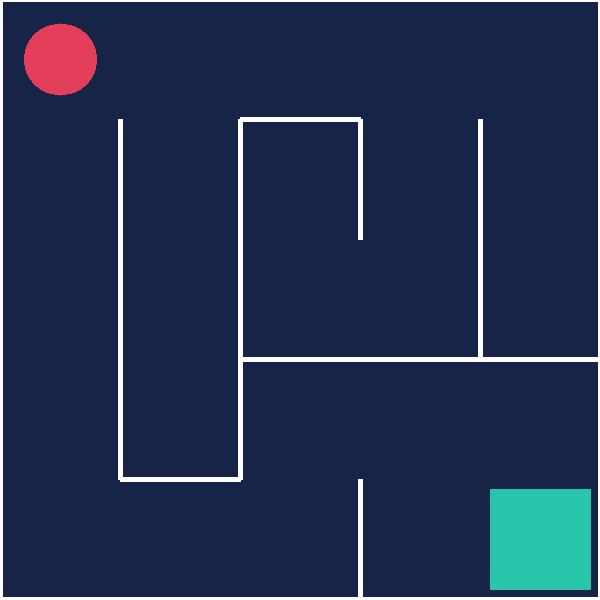

In [ ]:
env.render()

/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  spec = None


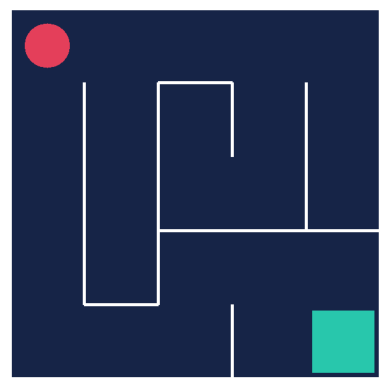

In [ ]:
frame = env.render(mode='rgb_array')
plt.imshow(frame)
plt.axis('off')
plt.show()

In [ ]:
action = 2
next_state, reward, done, info = env.step(action)
print(f"next state: {next_state}")
print(f"reward: {reward}")
print(f"done: {done}")
print(f"info: {info}")

next state: (1, 0)
reward: -1.0
done: False
info: {}


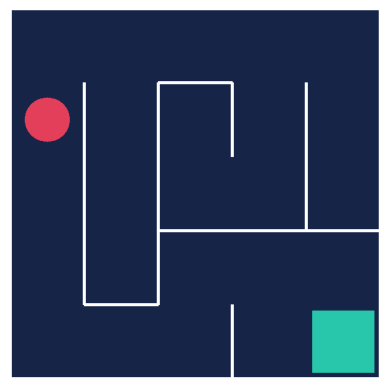

In [ ]:
frame = env.render(mode='rgb_array')
plt.imshow(frame)
plt.axis('off')
plt.show()

In [ ]:
initial_state = env.reset()
print(f"the new episode will start with state: {initial_state}")

the new episode will start with state: (0, 0)


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 22,  36,  71],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
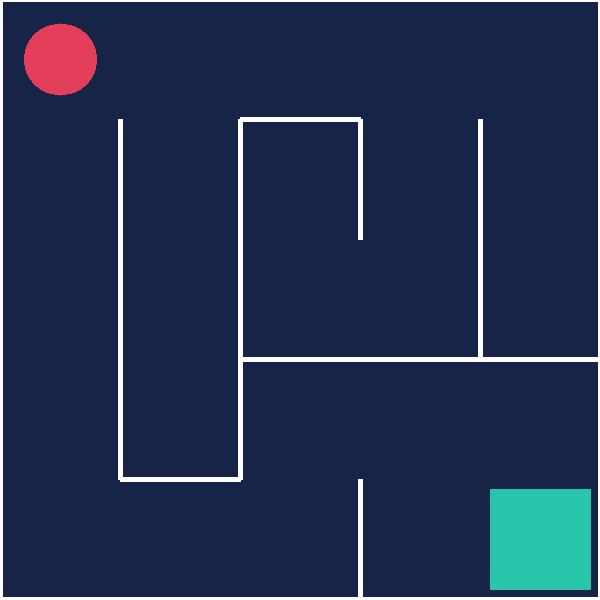

In [ ]:
env.render()

In [ ]:
print(f"the action state is of type: {env.action_space}")
print(f"the example state is of type: {env.action_space.sample()}")

the action state is of type: Discrete(4)
the example state is of type: 1


In [ ]:
import random

trajectory = []

state = env.reset()
next_state = state
trajectory.append((state, None, None, None, next_state))

for _ in range(3):
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    trajectory.append((state, action, reward, done, next_state))
    state = next_state

    if done:
        break

for state, action, reward, done, next_state in trajectory:
    print(f"State: {state}, Action: {action}, Reward: {reward}, Done: {done}, Next State: {next_state}")

State: (0, 0), Action: None, Reward: None, Done: None, Next State: (0, 0)
State: (0, 0), Action: 3, Reward: -1.0, Done: False, Next State: (0, 0)
State: (0, 0), Action: 0, Reward: -1.0, Done: False, Next State: (0, 0)
State: (0, 0), Action: 1, Reward: -1.0, Done: False, Next State: (0, 1)


In [ ]:

env = Maze()
frames = []
state = env.reset()
done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, _ = env.step(action)
    frame = env.render(mode='rgb_array')
    frames.append(frame)

env.close()

display_video(frames)


In [ ]:
print(trajectory)

[((0, 0), None, None, None, (0, 0)), ((0, 0), 3, -1.0, False, (0, 0)), ((0, 0), 0, -1.0, False, (0, 0)), ((0, 0), 1, -1.0, False, (0, 1))]


In [ ]:
state = env.reset()
trajectory = []
for i in range(3):
  action = env.action_space.sample()
  next_state,reward,Bool,info = env.step(action)
  trajectory.append((state,action,reward,next_state,Bool))
  state = next_state
env.close()
print(f"first trajectory:\n{trajectory}")

first trajectory:
[((0, 0), 1, -1.0, (0, 1), False), ((0, 1), 1, -1.0, (0, 2), False), ((0, 2), 3, -1.0, (0, 1), False)]


In [ ]:
state = env.reset()
trajectory = []
for i in range(3):
  action = env.action_space.sample()
  next_state,reward,Bool,info = env.step(action)
  trajectory.append((state,action,reward,next_state,Bool))
  state = next_state
env.close()
print(f"first trajectory:\n{trajectory}")

first trajectory:
[((0, 0), 2, -1.0, (1, 0), False), ((1, 0), 3, -1.0, (1, 0), False), ((1, 0), 1, -1.0, (1, 0), False)]


In [ ]:
env = Maze()
state = env.reset()
done =False
gamma = 0.99
G_0 = 0
t = 0
while not done:
  action = env.action_space.sample()
  _, reward, done, _ = env.step(action)
  G_0 += gamma ** t * reward
  t+=1
env.close()

In [ ]:
env = Maze()
state = env.reset()
done =False
episode = []
while not done:
  action = env.action_space.sample()
  next_state,reward,done,info = env.step(action)
  episode.append((state,action,reward,next_state,done))
  state = next_state
env.close()
print(f"first trajectory:\n{episode}")

first trajectory:
[((0, 0), 3, -1.0, (0, 0), False), ((0, 0), 0, -1.0, (0, 0), False), ((0, 0), 0, -1.0, (0, 0), False), ((0, 0), 0, -1.0, (0, 0), False), ((0, 0), 3, -1.0, (0, 0), False), ((0, 0), 0, -1.0, (0, 0), False), ((0, 0), 3, -1.0, (0, 0), False), ((0, 0), 0, -1.0, (0, 0), False), ((0, 0), 0, -1.0, (0, 0), False), ((0, 0), 0, -1.0, (0, 0), False), ((0, 0), 3, -1.0, (0, 0), False), ((0, 0), 2, -1.0, (1, 0), False), ((1, 0), 1, -1.0, (1, 0), False), ((1, 0), 1, -1.0, (1, 0), False), ((1, 0), 1, -1.0, (1, 0), False), ((1, 0), 0, -1.0, (0, 0), False), ((0, 0), 1, -1.0, (0, 1), False), ((0, 1), 3, -1.0, (0, 0), False), ((0, 0), 0, -1.0, (0, 0), False), ((0, 0), 3, -1.0, (0, 0), False), ((0, 0), 0, -1.0, (0, 0), False), ((0, 0), 1, -1.0, (0, 1), False), ((0, 1), 1, -1.0, (0, 2), False), ((0, 2), 0, -1.0, (0, 2), False), ((0, 2), 0, -1.0, (0, 2), False), ((0, 2), 2, -1.0, (0, 2), False), ((0, 2), 3, -1.0, (0, 1), False), ((0, 1), 1, -1.0, (0, 2), False), ((0, 2), 3, -1.0, (0, 1), Fal

# **CONCLUSION**
In this experiment, we successfully applied the concept of Markov Decision Processes (MDP) to solve a path planning problem. By modeling the environment as a set of states, actions, transition probabilities, and rewards, we were able to systematically determine an optimal policy that guides an agent from a start state to a goal state while maximizing cumulative rewards. Through iterative methods such as value iteration and policy iteration, the agent learned to navigate efficiently, even in environments with uncertainties.
This experiment demonstrated the effectiveness of MDPs in decision-making tasks under uncertainty, highlighting their importance in areas such as robotics, autonomous navigation, and artificial intelligence. Furthermore, it provided a strong foundational understanding of how mathematical frameworks like MDPs can be used to optimize complex planning problems in real-world scenarios.